**Import libraries and dependencies**

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as pl
import matplotlib.font_manager as fm
import scanpy as sc
import torch
import scvi
import scvelo as scv
import anndata
import re
import seaborn as sns
import cellrank as cr

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

/lustre/BIF/nobackup/perez070/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/lustre/BIF/nobackup/perez070/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/lustre/BIF/nobackup/perez070/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/lustre/BIF/nobackup/perez070/miniconda3/envs/regvelo-py310/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, Futur

In [2]:
# Matrix multiplication balancing precision and computational efficiency (options: medium-high-highest)
torch.set_float32_matmul_precision("high")

# Highest level of verbosity
sc.settings.verbosity = 3  
scv.settings.verbosity = 3

# Reproducibility
scvi.settings.seed = 1

# Figures
scv.set_figure_params(style="scvelo")

# Use Times New Roman as font
font_path = '/lustre/BIF/nobackup/perez070/scRNA-seq_PLT1-WOX5/supp_data/misc/Times_New_Roman.ttf'
fm.fontManager.addfont(font_path)
prop = fm.FontProperties(fname=font_path)
pl.rcParams['font.family'] = 'sans-serif'
pl.rcParams['font.sans-serif'] = prop.get_name()

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

Seed set to 1


In [3]:
# Select samples
os.chdir('/lustre/BIF/nobackup/perez070/scRNA-seq_PLT1-WOX5/output/1-2_scKB_mapping')
samples = ['0h_1_scKB','0h_2_scKB','2h_1_scKB','2h_2_scKB','4h_1_scKB','4h_2_scKB','10h_1_scKB','10h_2_scKB']

# Directory with multiple files required below
analysis_dir = '/lustre/BIF/nobackup/perez070/scRNA-seq_PLT1-WOX5/supp_data/misc/'

In [4]:
adata_0h = anndata.read_h5ad('/lustre/BIF/nobackup/perez070/scRNA-seq_PLT1-WOX5/output/3-2_anndata_obj/sctour_pseudotime_0h.h5ad')

In [5]:
print(adata_0h)

AnnData object with n_obs × n_vars = 6950 × 2000
    obs: 'sample', 'batch', 'experiment', 'final_celltype', 'final_annotation_developmental_0.7', 'final_lineages', 'final_annotation_MINI-EX', 'pseudotime', 'n_genes_by_counts', 'total_counts', 'ptime_reversed'
    var: 'gene_symbol', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'experiment_colors', 'final_annotation_developmental_0.7_colors', 'final_celltype_colors', 'final_lineages_colors', 'hvg', 'neighbors', 'umap'
    obsm: 'X_TNODE', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'


In [ ]:
# Compute transition matrix with pseudotime kernel
sc.pp.neighbors(adata_0h)
pk = cr.kernels.PseudotimeKernel(adata_0h, time_key="ptime_reversed")
pk.compute_transition_matrix()

computing neighbors
computing PCA
    with n_comps=50


    finished (0:00:00)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)


100%|██████████| 6950/6950 [00:01<00:00, 5702.98cell/s]


PseudotimeKernel[n=6950, dnorm=False, scheme='hard', frac_to_keep=0.3]

GPCCA[kernel=PseudotimeKernel[n=6950], initial_states=None, terminal_states=None]


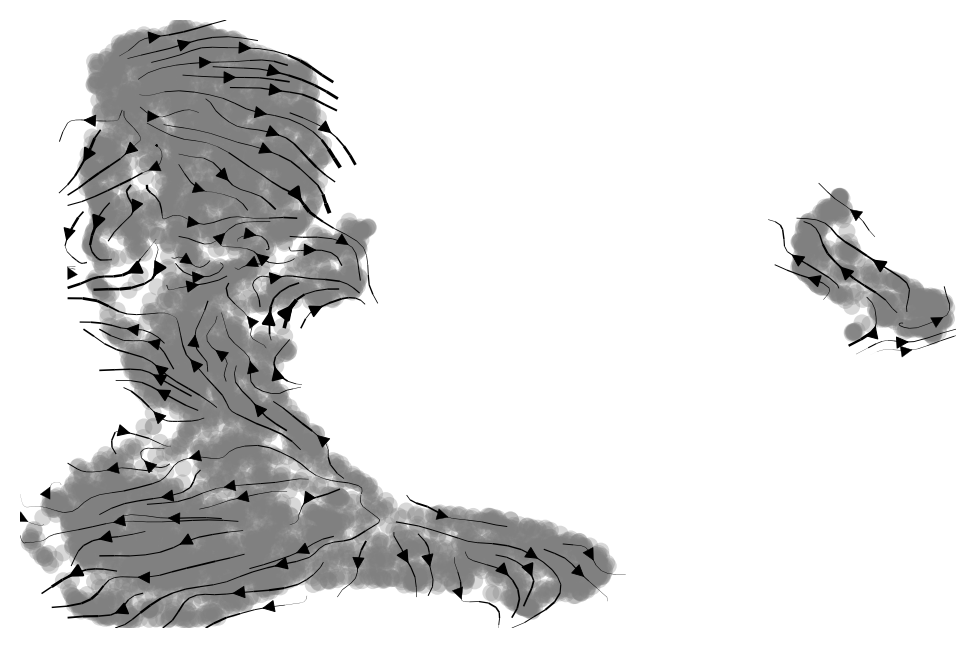

In [7]:
g = cr.estimators.GPCCA(pk)
print(g)
pk.plot_projection()

In [ ]:
def analyze_cell_fate(adata_0h, selected_cell_types):
    """
    Analyzes cell fate probabilities, filters data, and plots results.
    
    Parameters:
        adata_10h (AnnData): Single-cell dataset.
        selected_cell_types (list): List of cell types to include.
    """

    # Filter cells where 'final_annotation_developmental_0.7' is "Maturation" or 'final_celltype' is "Unknown0"
    adata_0h = adata_0h[adata_0h.obs["final_annotation_developmental_0.7"].isin(["Maturation"]) | adata_0h.obs["final_celltype"].isin(["Unknown0"])].copy()
    
    # Create terminal states dictionary
    terminal_states_dict = {}
    others_cell_ids = []

    for state in adata_0h.obs["final_celltype"].unique():
        cell_type_cells = adata_0h[adata_0h.obs["final_celltype"] == state]
        sorted_cells = cell_type_cells.obs.sort_values(by="ptime_reversed", ascending=False)

        if state == "Unknown0":
            # Select top 99% of "Unknown0"
            top_cells = sorted_cells.head(int(len(sorted_cells) * 0.284))
        else:
            # Select top 10% of all other cell types
            top_cells = sorted_cells.head(int(len(sorted_cells) * 0.2))
        
        cell_ids = top_cells.index.tolist()

        if state in selected_cell_types:
            terminal_states_dict[state] = cell_ids
        else:
            others_cell_ids.extend(cell_ids)

    terminal_states_dict["Others"] = others_cell_ids

    # Set terminal states in dynamo
    g.set_terminal_states(states=terminal_states_dict)
    print(terminal_states_dict)

    # Plot macrostates and compute fate probabilities
    g.plot_macrostates(which="terminal", legend_loc="right", size=10)
    g.compute_fate_probabilities(tol=1e-12)
    g.plot_fate_probabilities(same_plot=False)
    g.plot_fate_probabilities(same_plot=True)

    # Modify cell annotations
    adata_0h.obs["Maturation"] = adata_0h.obs["final_celltype"].apply(
        lambda x: x if x in selected_cell_types else "Others"
    )
    adata_0h.obs["Maturation"] = pd.Categorical(adata_0h.obs["Maturation"])
    adata_filtered = adata_0h[adata_0h.obs["Maturation"] != "Others"].copy()


    # Define custom palette
    custom_palette = {
        "Atrichoblast": "#E69F00", 
        "Columella": "magenta",
        "Cortex": "blue", 
        "Endodermis": "#000000", 
        "Lateral Root Cap": "gold",
        "Metaphloem & Companion Cell": "black", 
        "Metaxylem": "black", 
        "Others": "yellow",
        "Phloem Pole Pericycle": "black", 
        "Procambium": "black", 
        "Protophloem": "black", 
        "Protoxylem": "black", 
        "Quiescent Center": "#2CA02C",
        "Trichoblast": "#D62728", 
        "Unknown0": "black",
        "Xylem Pole Pericycle": "black",
        "Unknown1": "yellow", 
        "Unknown2": "blue",
        "Unknown3": "pink",
        "Unknown4": "red",
        "Unknown5": "purple",
        "Unknown6": "orange",
        "Unknown7": "magenta",
        "Unknown8": "olive",
        "Unknown9": "black",
        "Unknown10": "khaki",
        "Unknown11": "darkslategrey"
    }

    custom_palette_lineages = {
        "Epidermis": "#E69F00", 
        "Root Cap": "#56B4E9", 
        "Stele": "#00000", 
        "Ground Tissue": "#F0E442", 
        "Mixed identity": "#0072B2", 
    }


    # Set global font sizes before the plot
    mpl.rcParams['axes.titlesize'] = 18
    mpl.rcParams['axes.labelsize'] = 16
    mpl.rcParams['xtick.labelsize'] = 16
    mpl.rcParams['ytick.labelsize'] = 16
    mpl.rcParams['legend.fontsize'] = 14


    # Plot circular projection
    cr.pl.circular_projection(
        adata_filtered, 
        keys=["Maturation"], 
        lineages=selected_cell_types, 
        legend_loc="right", 
        key_added="cellfate_result",
        frameon=False,
        figsize=(56,8)
    )
    
        # Get current axis
    fig = pl.gcf()
    ax = pl.gca()

    # Recolor polygon labels manually
    for text in ax.texts:
        label = text.get_text()
        if label in custom_palette:
            text.set_color(custom_palette[label])

    pl.tight_layout()
    pl.show()


    cr.pl.aggregate_fate_probabilities(
    adata_filtered,
    mode="violin",
    lineages=["Unknown0"],
    cluster_key="final_celltype",
    clusters=selected_cell_types,
    figsize=(6,6)
    )   

    fig = pl.gcf()
    ax = pl.gca()

    ax.set_title("Unknown0", fontsize=14)
    ax.set_xlabel("")
    ax.set_ylabel("Fate probability", fontsize=13)
    pl.xticks(rotation=45, ha="right", rotation_mode="anchor", fontsize=12)
    pl.yticks(fontsize=12)
    pl.tight_layout()

    cr.pl.aggregate_fate_probabilities(
    adata_filtered,
    mode="violin",
    lineages=["Xylem Pole Pericycle"],
    cluster_key="final_celltype",
    clusters=selected_cell_types,
    figsize=(6,6)
    )   

    fig = pl.gcf()
    ax = pl.gca()

    ax.set_title("Xylem pole pericycle", fontsize=14)
    ax.set_xlabel("")
    ax.set_ylabel("Fate probability", fontsize=13)
    pl.xticks(rotation=45, ha="right", rotation_mode="anchor", fontsize=12)
    pl.yticks(fontsize=12)
    pl.tight_layout()

    cr.pl.aggregate_fate_probabilities(
    adata_filtered,
    mode="violin",
    lineages=["Phloem Pole Pericycle"],
    cluster_key="final_celltype",
    clusters=selected_cell_types,
    figsize=(6,6)
    )   

    fig = pl.gcf()
    ax = pl.gca()

    ax.set_title("Phloem pole pericycle", fontsize=14)
    ax.set_xlabel("")
    ax.set_ylabel("Fate probability", fontsize=13)
    pl.xticks(rotation=45, ha="right", rotation_mode="anchor", fontsize=12)
    pl.yticks(fontsize=12)
    pl.tight_layout()

    cr.pl.aggregate_fate_probabilities(
    adata_filtered,
    mode="violin",
    lineages=["Procambium"],
    cluster_key="final_celltype",
    clusters=selected_cell_types,
    )   

    cr.pl.aggregate_fate_probabilities(
    adata_filtered,
    mode="violin",
    lineages=["Protoxylem"],
    cluster_key="final_celltype",
    clusters=selected_cell_types,
    )   

    cr.pl.aggregate_fate_probabilities(
    adata_filtered,
    mode="violin",
    lineages=["Metaphloem & Companion Cell"],
    cluster_key="final_celltype",
    clusters=selected_cell_types,
    )   

    return adata_0h


{'Xylem Pole Pericycle': ['6774', '490', '3022', '3558-1', '8059', '3795-1', '3538-1', '4463-1', '6888', '2617', '2873-1', '1461', '5577', '5353', '6333-1', '412-1', '7077', '5958', '3284-1', '3616', '1072-1', '5890', '5045', '6385', '5012', '2344', '2567-1', '3820', '5370-1', '8269', '3654', '4019-1', '370-1', '1185-1', '3666-1', '5716', '5680', '992-1', '5982-1', '3493', '3760-1', '3887', '4409', '6717-1', '5033-1', '3828', '6066-1', '342', '1806-1', '8207', '5328', '3048-1', '5230', '5717', '8114', '5496', '6040-1', '4534-1', '3302', '1306', '7896', '352', '6004-1', '2251', '6168', '5016', '7931', '5315', '963-1', '986', '1162', '3204', '1369-1', '1316', '7407', '1957-1', '3806-1', '4805', '5817', '377-1', '5517', '6617-1', '2125-1', '4303-1', '2980-1', '5420', '1863', '832', '5404', '4793-1', '8265', '1736-1', '5767', '3565-1', '4673', '249-1', '199', '5658', '2767', '1907-1', '4189', '2422', '1893-1', '4715', '793-1', '3159-1', '5648-1', '1775-1', '4904', '5951-1', '504-1', '5237-

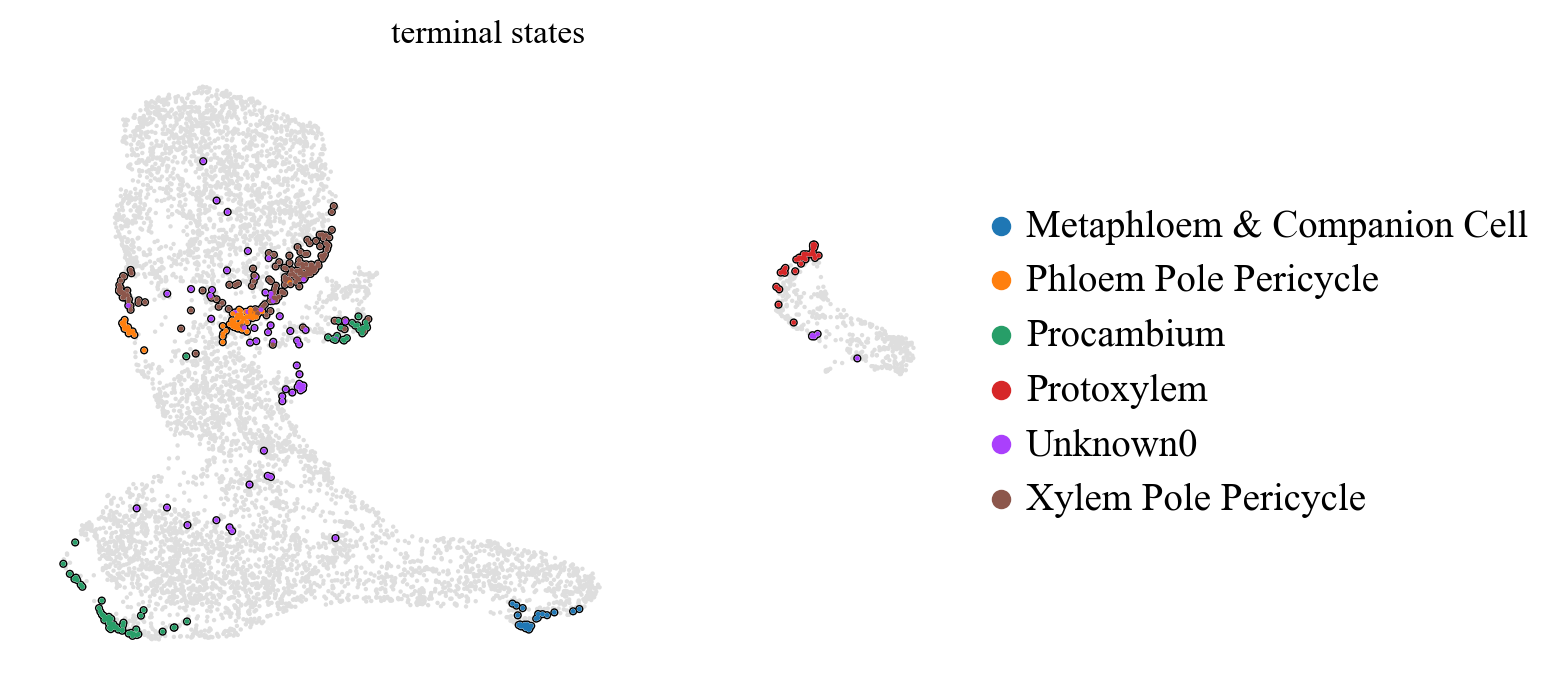

100%|██████████| 6/6 [00:00<00:00, 21.60/s]


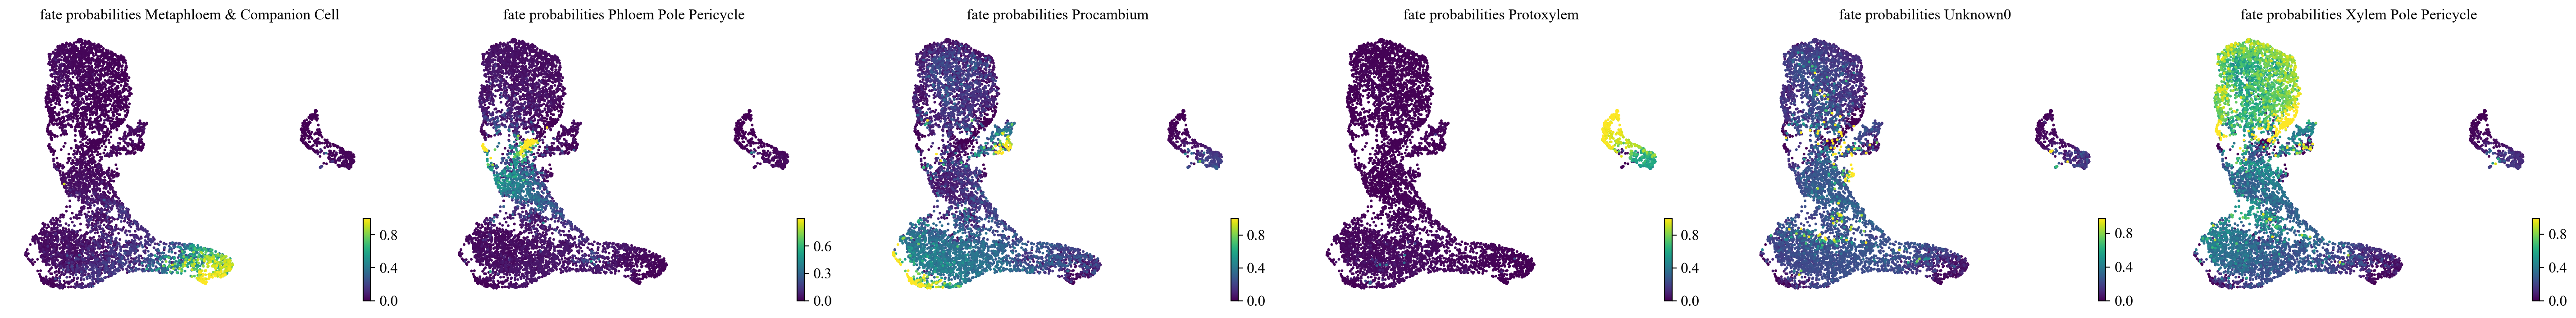

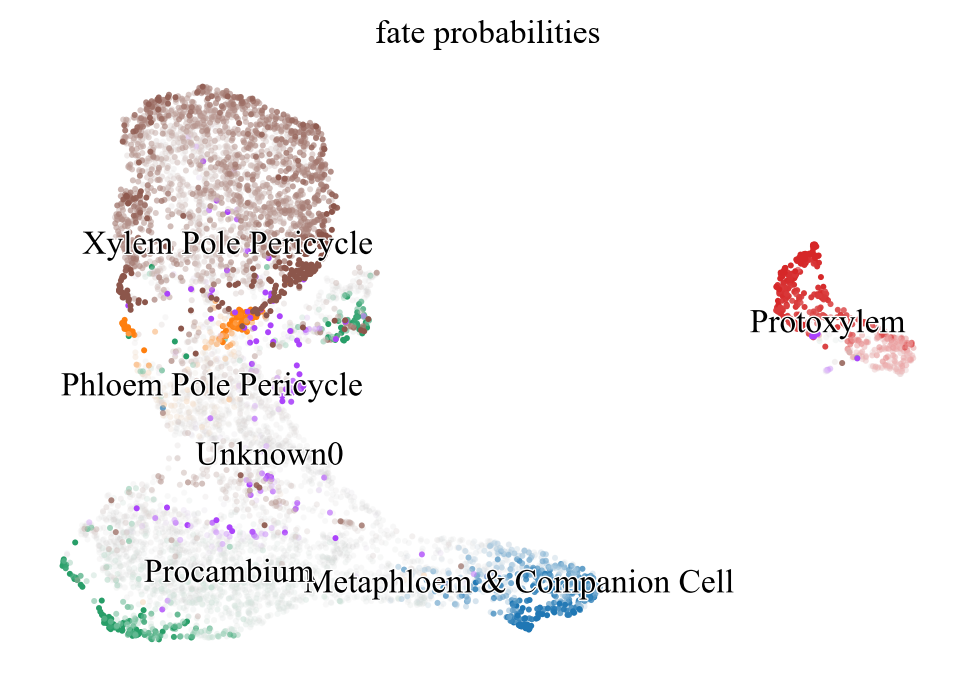

Renamed 'cellfate_result' to convention 'X_cellfate_result' (adata.obsm).


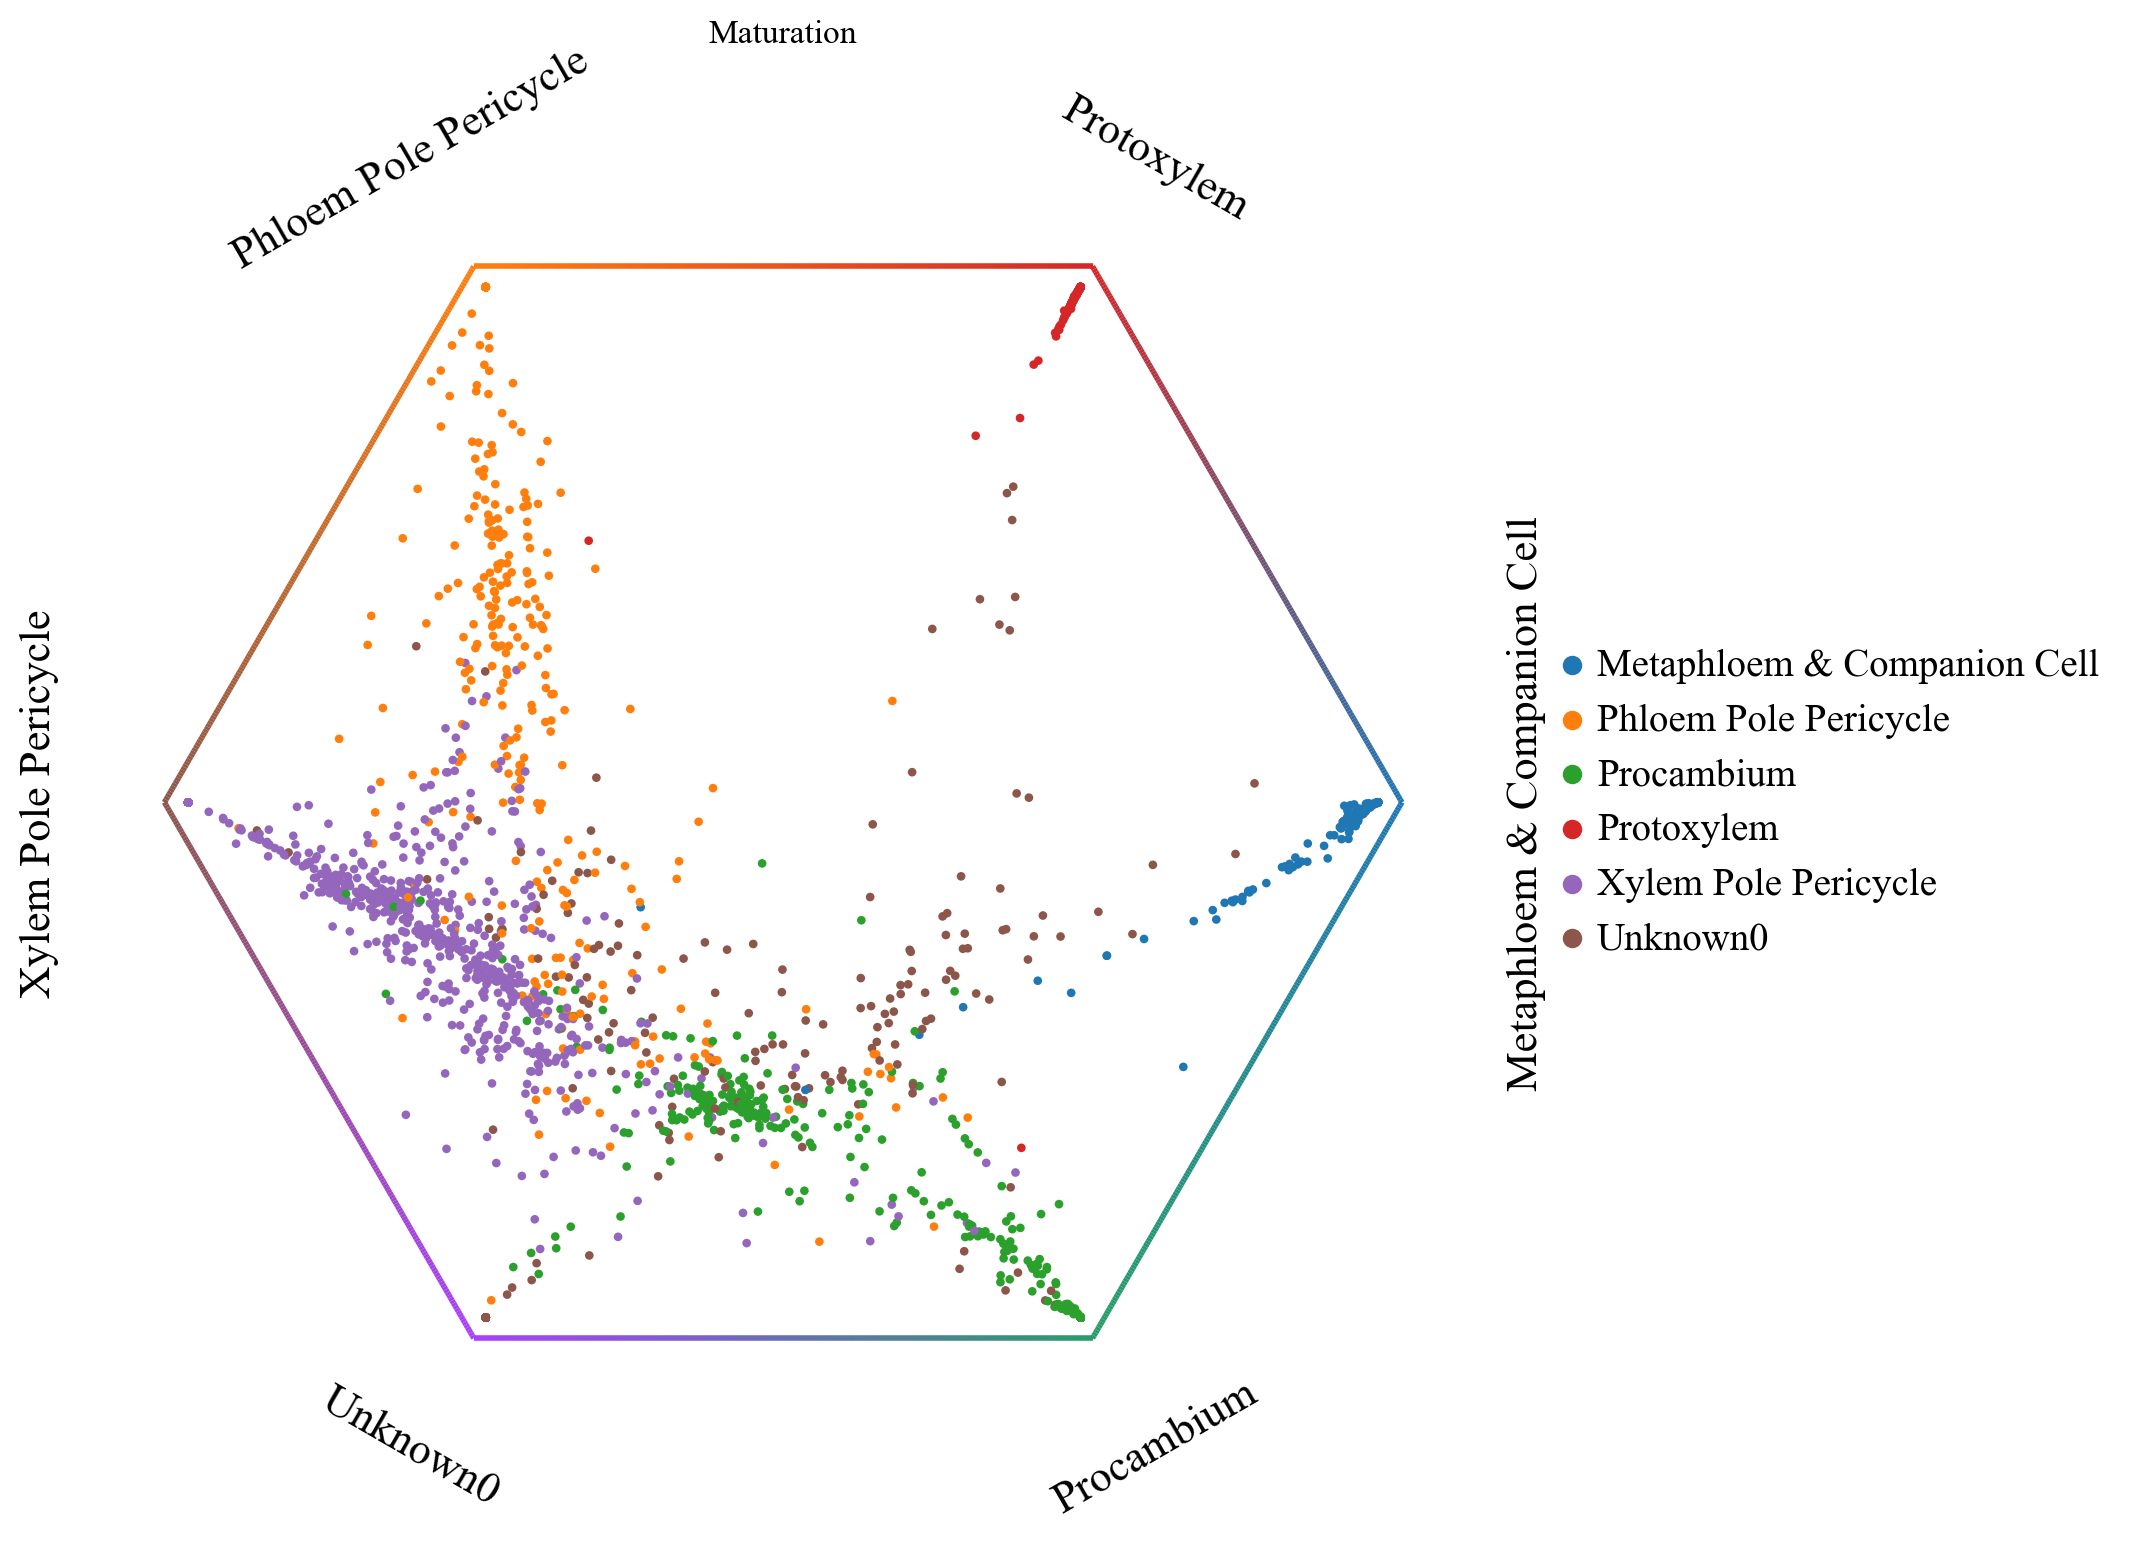

AnnData object with n_obs × n_vars = 2076 × 2000
    obs: 'sample', 'batch', 'experiment', 'final_celltype', 'final_annotation_developmental_0.7', 'final_lineages', 'final_annotation_MINI-EX', 'pseudotime', 'n_genes_by_counts', 'total_counts', 'ptime_reversed', 'term_states_fwd', 'clusters_gradients', 'Maturation'
    var: 'gene_symbol', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'experiment_colors', 'final_annotation_developmental_0.7_colors', 'final_celltype_colors', 'final_lineages_colors', 'hvg', 'neighbors', 'umap', 'pca', 'T_fwd_params', 'term_states_fwd_colors', 'clusters_gradients_colors'
    obsm: 'X_TNODE', 'X_umap', 'X_pca', 'T_fwd_umap', 'lineages_fwd'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

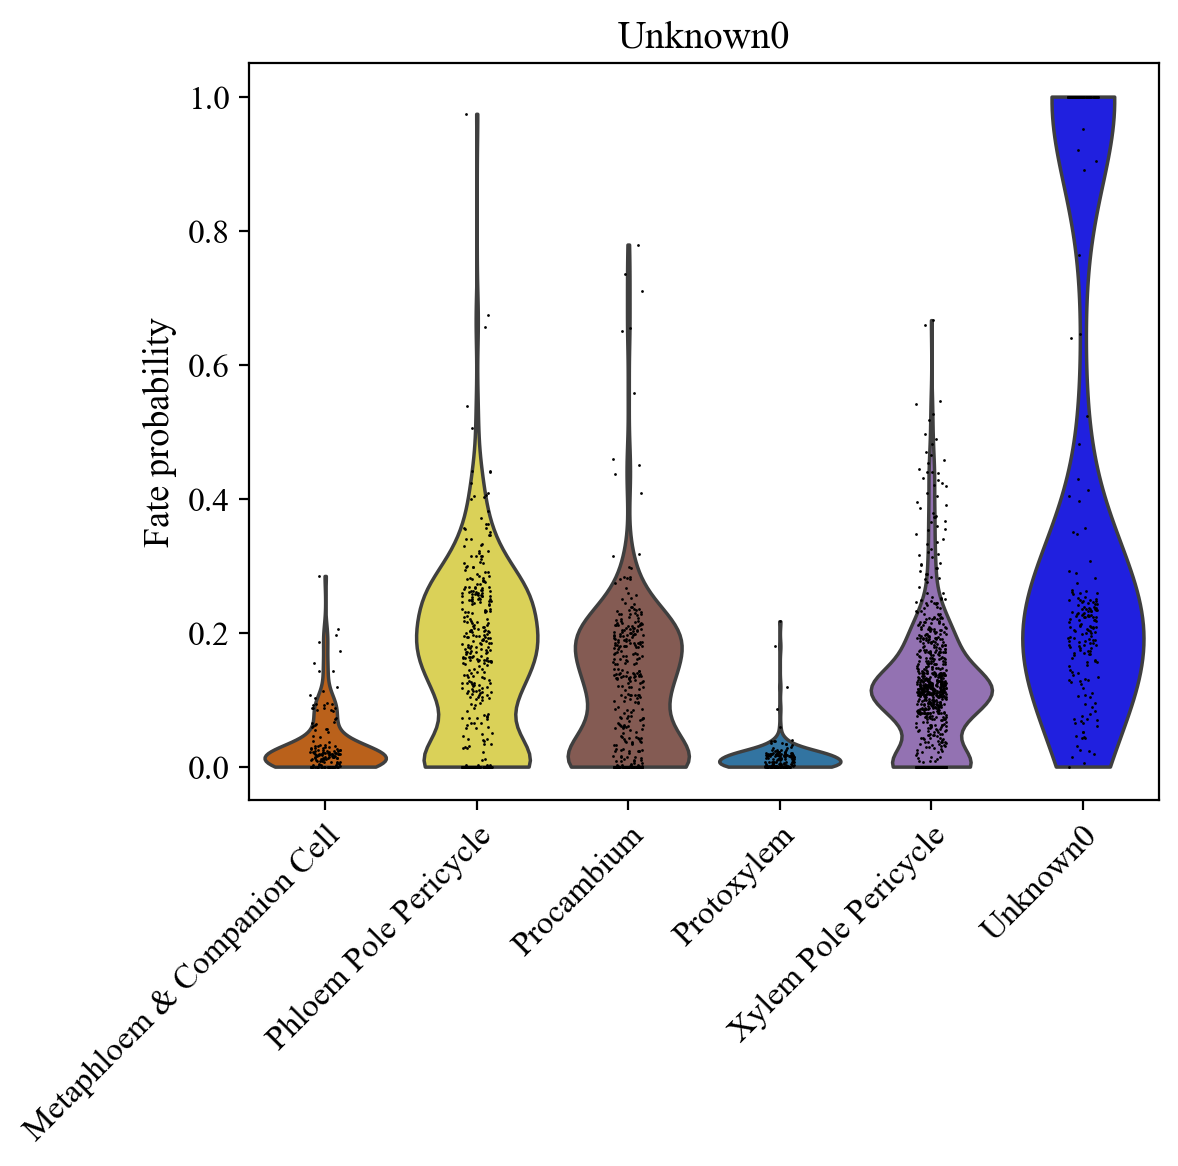

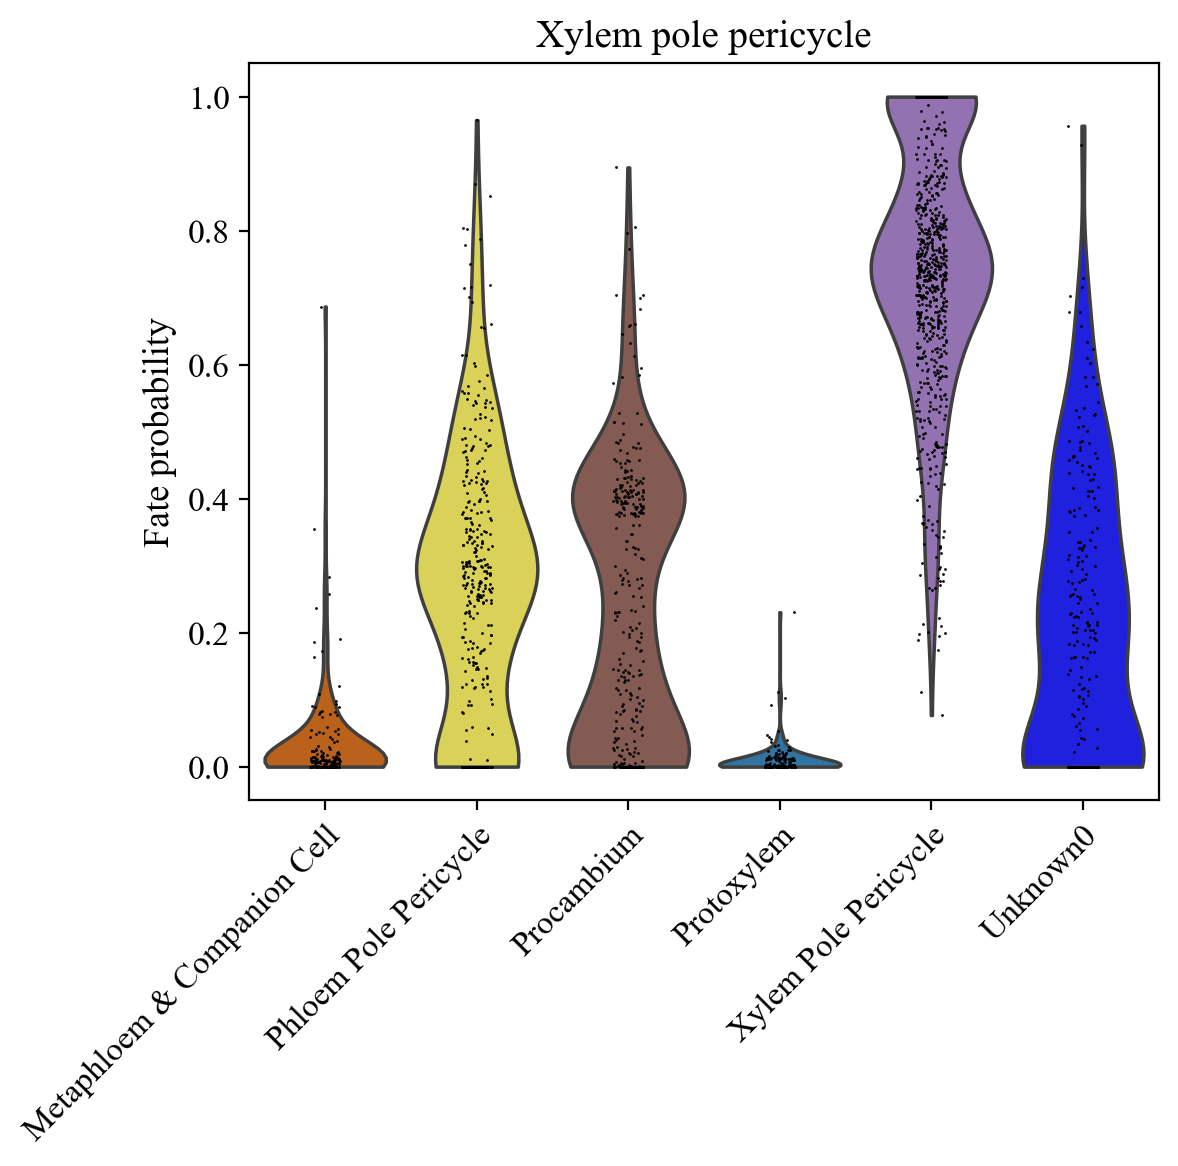

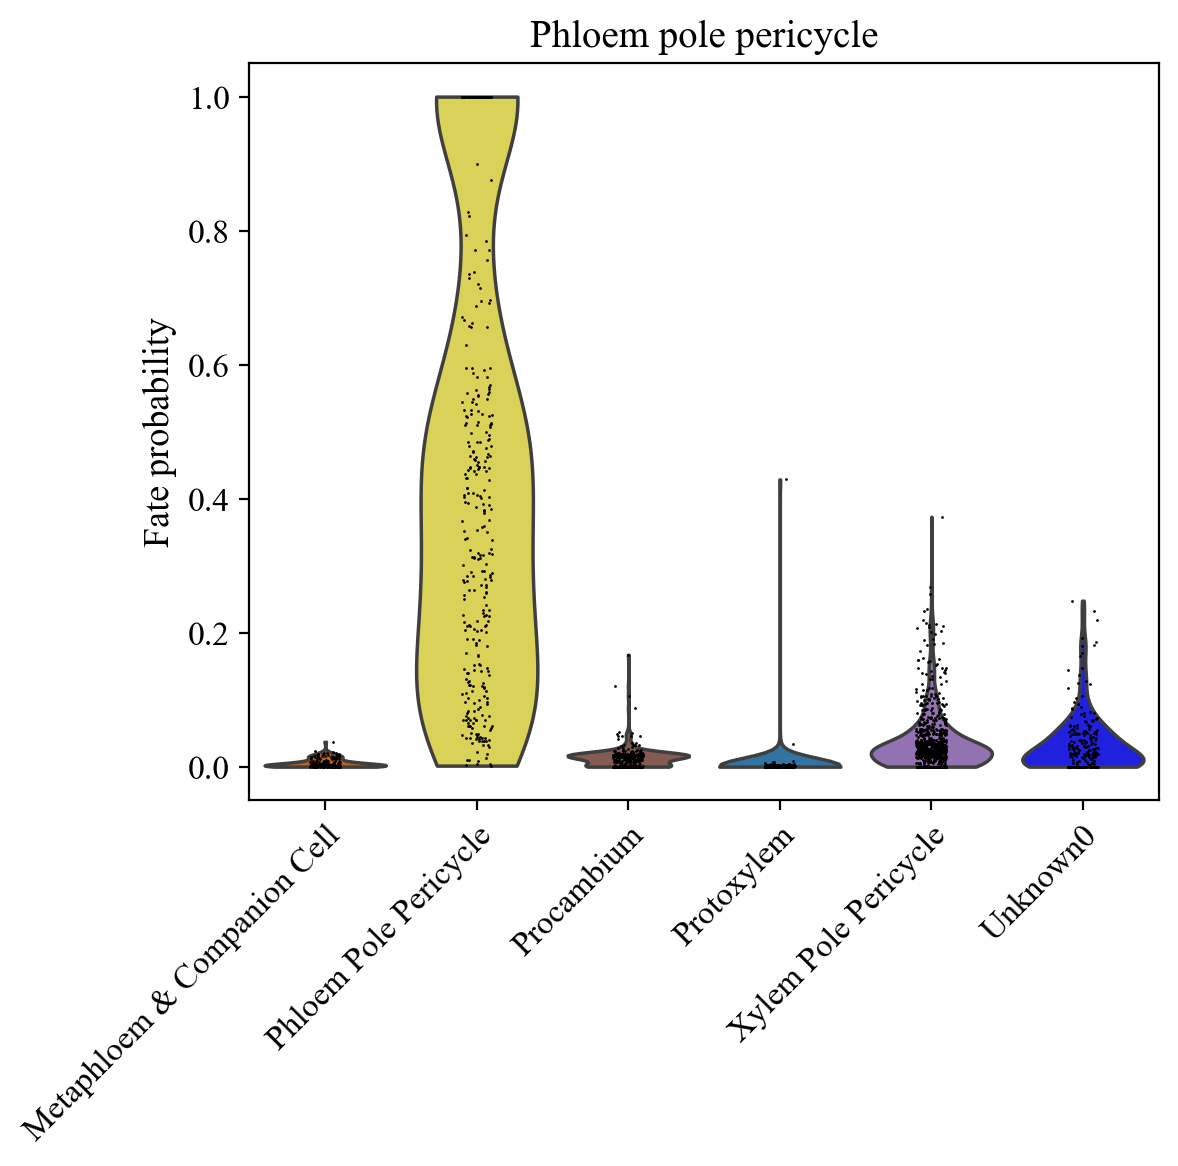

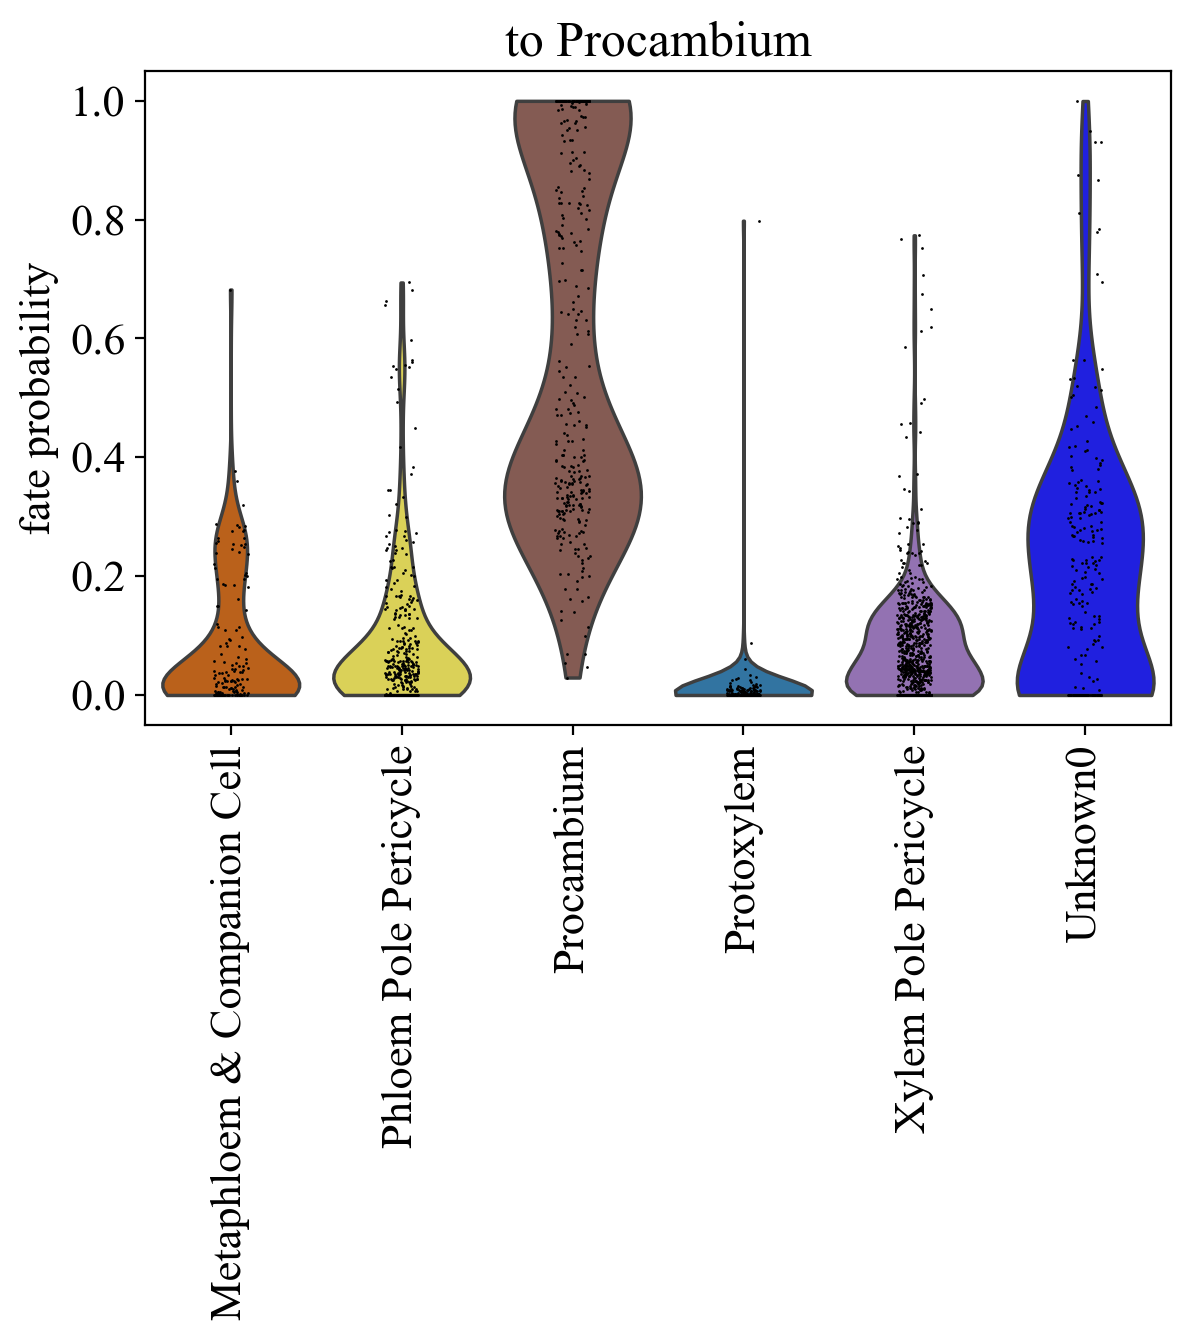

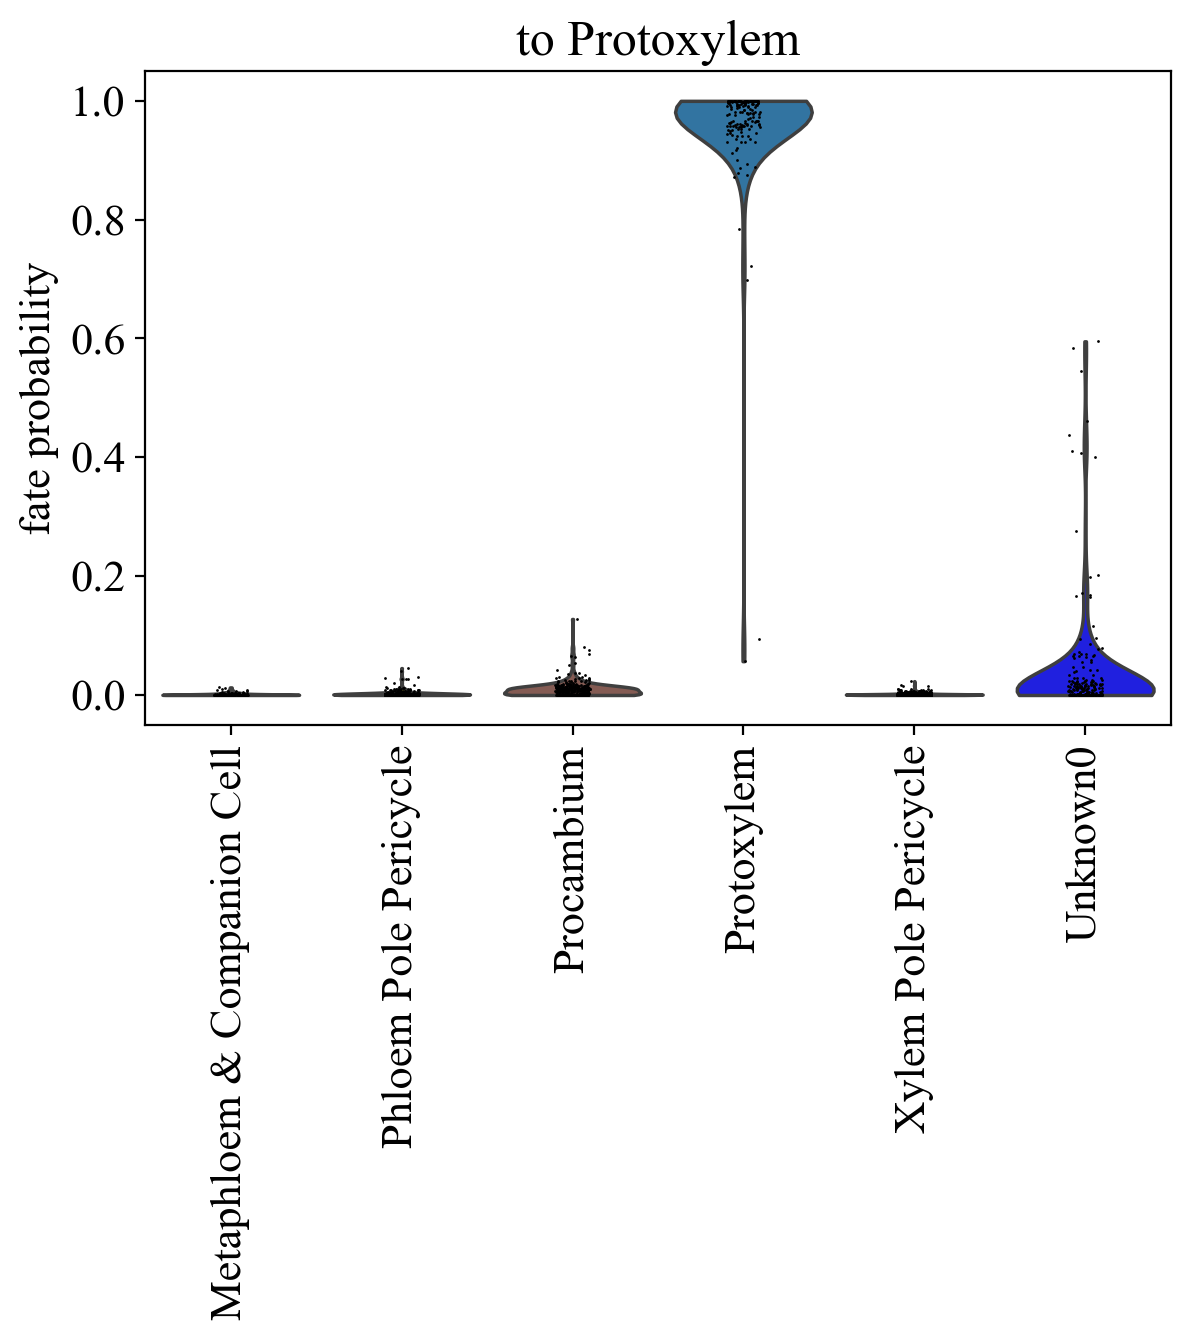

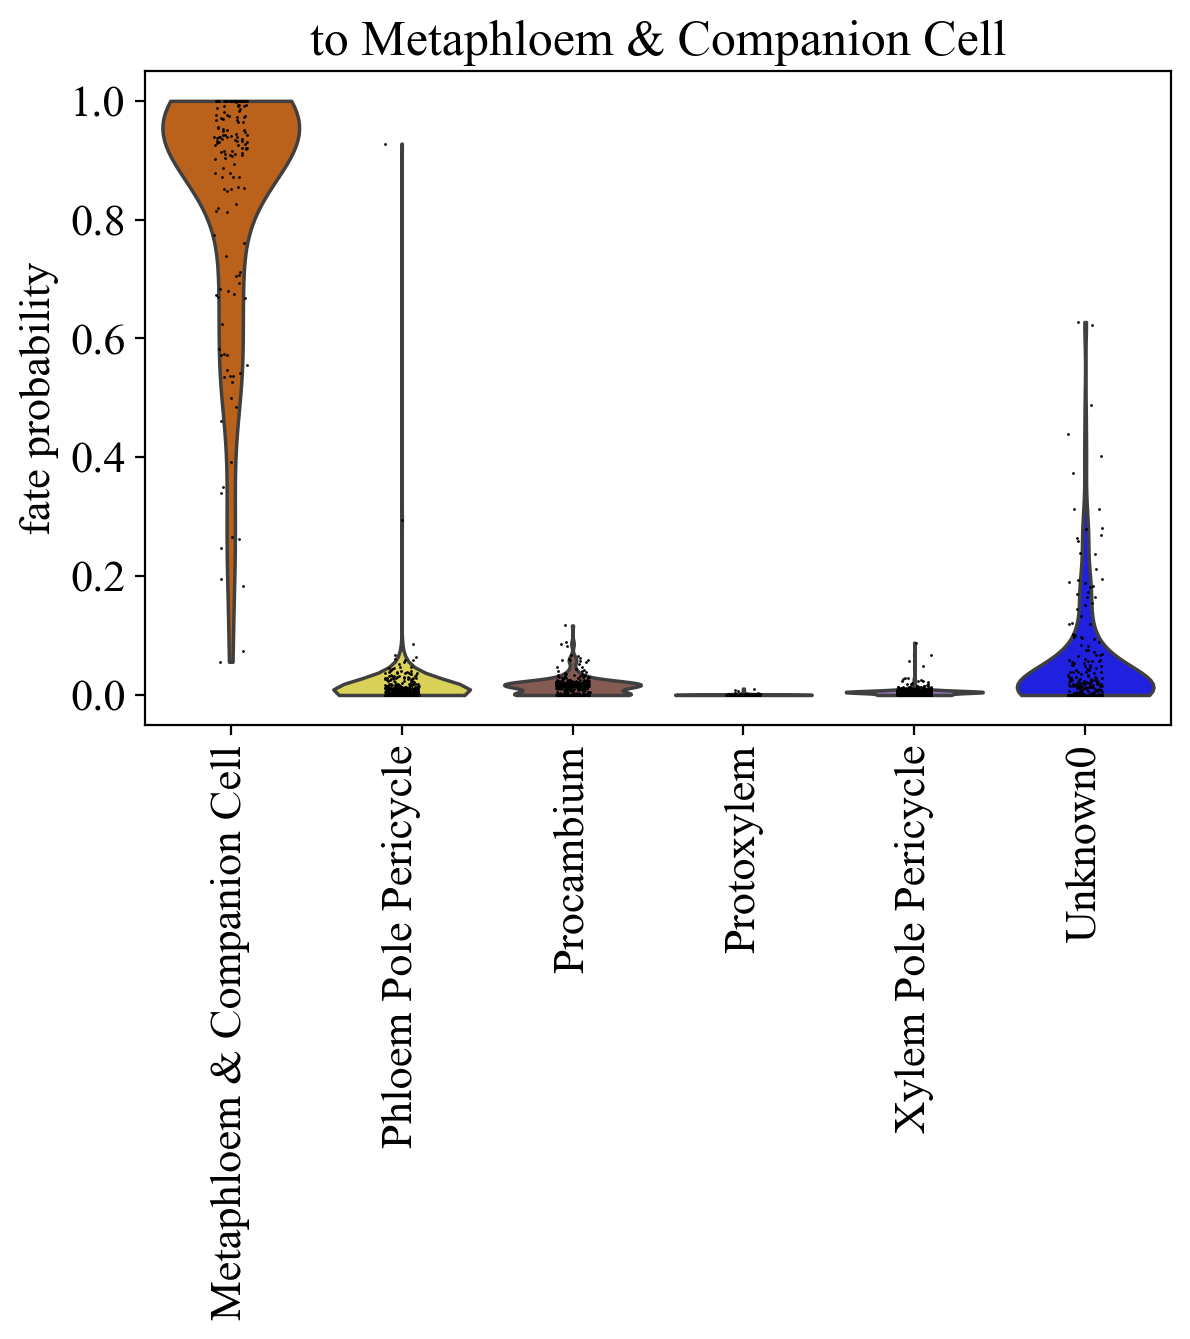

In [12]:
analyze_cell_fate(adata_0h, [
    #"Epidermis",
    #"Root Cap",
    #"Stele",
    #"Ground Tissue",
    #"Atrichoblast",
    #"Columella", 
    #"Cortex", 
    #"Endodermis", 
    #"Lateral Root Cap", 
    #"LRPI",
    "Metaphloem & Companion Cell", 
    #"Metaxylem", 
    "Phloem Pole Pericycle", 
    "Procambium", 
    #"Protophloem", 
    "Protoxylem", 
    #"Quiescent Center",
    #"Trichoblast", 
    "Unknown0",
    "Xylem Pole Pericycle",
    #"Unknown1", 
    #"Unknown2",
    #"Unknown3",
    #"Unknown4",
    #"Unknown5",
    #"Unknown6",
    #"Unknown7",
    #"Unknown8",
    #"Unknown9",
    #"Unknown10",
    #"Unknown11"])
    #"Others"
    ])